# Computer Vision Project - Object Detection
  Aswathy B  ID:210200003 , SCDS SEM -7

In [1]:
# To install libraries
!pip3 install -q ultralytics matplotlib opencv-python pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 904.4/904.4 kB 20.2 MB/s eta 0:00:00


In [2]:
#Import the libraries
import random
import json
import os
import shutil
from zipfile import ZipFile
import requests
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [3]:
def create_dataset_structure(data_dir):
    os.makedirs(os.path.join(data_dir, "train", "images"), exist_ok=True)
    os.makedirs(os.path.join(data_dir, "train", "labels"), exist_ok=True)
    os.makedirs(os.path.join(data_dir, "test", "images"), exist_ok=True)
    os.makedirs(os.path.join(data_dir, "test", "labels"), exist_ok=True)

dataset_name = "car_parts_dataset"
create_dataset_structure(dataset_name)

In [4]:
# To download the dataset
dataset_url = "https://github.com/dsmlr/Car-Parts-Segmentation/archive/refs/heads/master.zip"
dataset_zip_file = "car_parts_dataset.zip"
download_response = requests.get(dataset_url)

with open(dataset_zip_file, "wb") as file:
    file.write(download_response.content)

with ZipFile(dataset_zip_file, 'r') as zip_ref:
    zip_ref.extractall(".")

extracted_dataset_dir = "Car-Parts-Segmentation-master"
training_images_dir = os.path.join(extracted_dataset_dir, "trainingset", "JPEGImages")
training_annotations_file = os.path.join(extracted_dataset_dir, "trainingset", "annotations.json")
testing_images_dir = os.path.join(extracted_dataset_dir, "testset", "JPEGImages")
testing_annotations_file = os.path.join(extracted_dataset_dir, "testset", "annotations.json")

try:
    if os.path.exists(training_images_dir):
        shutil.move(training_images_dir, os.path.join(dataset_name, "train", "images"))
    else:
        print("Training images folder not found. Check extracted contents.")

    if os.path.exists(training_annotations_file):
        shutil.move(training_annotations_file, os.path.join(dataset_name, "train", "annotations.json"))
    else:
        print("Training annotations file not found. Check extracted contents.")

    if os.path.exists(testing_images_dir):
        shutil.move(testing_images_dir, os.path.join(dataset_name, "test", "images"))  # Using dataset_name
    else:
        print("Testing images folder not found. Check extracted contents.")

    if os.path.exists(testing_annotations_file):
        shutil.move(testing_annotations_file, os.path.join(dataset_name, "test", "annotations.json"))  # Using dataset_name
    else:
        print("Testing annotations file not found. Check extracted contents.")
except Exception as e:
    print(f"Error during file organization: {e}")

os.remove(dataset_zip_file)
shutil.rmtree(extracted_dataset_dir, ignore_errors=True)

print("Downloaded and organised into the Yolo required format.")

Downloaded and organised into the Yolo required format.


In [5]:
def transfer_and_delete_folder(source_dir, destination_dir):
    os.makedirs(destination_dir, exist_ok=True)

    for file_name in os.listdir(source_dir):
        source_file = os.path.join(source_dir, file_name)
        destination_file = os.path.join(destination_dir, file_name)
        shutil.move(source_file, destination_file)

    os.rmdir(source_dir)

In [6]:
def coco_to_yolo(bounding_box, image_width, image_height):
    """Converts a COCO bounding box to YOLO format."""
    x, y, width, height = bounding_box
    x_center = (x + width / 2) / image_width
    y_center = (y + height / 2) / image_height
    width /= image_width
    height /= image_height
    return x_center, y_center, width, height

In [7]:
train_images_src = os.path.join(dataset_name, "train", "images", "JPEGImages")
train_images_dest = os.path.join(dataset_name, "train", "images")
transfer_and_delete_folder(train_images_src, train_images_dest)

test_images_src = os.path.join(dataset_name, "test", "images", "JPEGImages")
test_images_dest = os.path.join(dataset_name, "test", "images")
transfer_and_delete_folder(test_images_src, test_images_dest)

In [8]:
def process_subset(subset_dir, annotations_file):
    """Processes a single subset (train or test) and converts annotations to YOLO format."""
    with open(annotations_file, "r") as f:
        annotations_data = json.load(f)

    for image_info in annotations_data["images"]:
        image_id = image_info["id"]
        image_name = image_info["file_name"]
        image_width = image_info["width"]
        image_height = image_info["height"]

        yolo_label_file = os.path.join(subset_dir, "labels", image_name.replace(".jpg", ".txt"))
        with open(yolo_label_file, "w") as lf:
            for annotation in annotations_data["annotations"]:
                if annotation["image_id"] == image_id:
                    bounding_box = annotation["bbox"]
                    class_id = annotation["category_id"]
                    yolo_bbox = coco_to_yolo(bounding_box, image_width, image_height)
                    lf.write(f"{class_id} {yolo_bbox[0]} {yolo_bbox[1]} {yolo_bbox[2]} {yolo_bbox[3]}\n")

# Main processing loop
for subset in ["train", "test"]:
    subset_dir = os.path.join(dataset_name, subset)
    annotations_file = os.path.join(subset_dir, "annotations.json")

    if not os.path.exists(annotations_file):
        raise FileNotFoundError(f"Annotations file not found in {subset} folder: {annotations_file}")

    process_subset(subset_dir, annotations_file)

print("Annotations parsed, converted to YOLO format.")

Annotations parsed, converted to YOLO format.


In [9]:
import os

def adjust_class_labels(labels_directory):
    """Reduces class IDs by 2 in YOLO label files within the given directory."""
    for label_filename in os.listdir(labels_directory):
        label_filepath = os.path.join(labels_directory, label_filename)

        if os.path.isfile(label_filepath) and label_filename.endswith('.txt'):
            with open(label_filepath, "r") as label_file:
                file_lines = label_file.readlines()

            modified_lines = []
            for line in file_lines:
                line_parts = line.strip().split()
                if line_parts:
                    original_class_id = int(line_parts[0])
                    adjusted_class_id = original_class_id - 2

                    if adjusted_class_id < 0:
                        print(f"Warning: Invalid class ID in {label_filename}: {line.strip()}")
                        continue

                    modified_line = f"{adjusted_class_id} " + " ".join(line_parts[1:]) + "\n"
                    modified_lines.append(modified_line)

            with open(label_filepath, "w") as label_file:
                label_file.writelines(modified_lines)
            print(f"Updated class IDs in {label_filename}")

training_labels_dir = "/content/car_parts_dataset/train/labels"
testing_labels_dir = "/content/car_parts_dataset/test/labels"

adjust_class_labels(training_labels_dir)
adjust_class_labels(testing_labels_dir)

Updated class IDs in train75.txt
Updated class IDs in train61.txt
Updated class IDs in train133.txt
Updated class IDs in train335.txt
Updated class IDs in train302.txt
Updated class IDs in train56.txt
Updated class IDs in train357.txt
Updated class IDs in train43.txt
Updated class IDs in train95.txt
Updated class IDs in train262.txt
Updated class IDs in train21.txt
Updated class IDs in train202.txt
Updated class IDs in train225.txt
Updated class IDs in train333.txt
Updated class IDs in train99.txt
Updated class IDs in train153.txt
Updated class IDs in train193.txt
Updated class IDs in train63.txt
Updated class IDs in train244.txt
Updated class IDs in train82.txt
Updated class IDs in train42.txt
Updated class IDs in train322.txt
Updated class IDs in train3.txt
Updated class IDs in train130.txt
Updated class IDs in train310.txt
Updated class IDs in train352.txt
Updated class IDs in train303.txt
Updated class IDs in train214.txt
Updated class IDs in train372.txt
Updated class IDs in train

In [10]:
import os
import random
import shutil

def split_data(data_source_dir, train_data_dir, val_data_dir, split_ratio=0.75):
    """Splits the dataset into training and validation sets."""

    os.makedirs(os.path.join(train_data_dir, "images"), exist_ok=True)
    os.makedirs(os.path.join(train_data_dir, "labels"), exist_ok=True)
    os.makedirs(os.path.join(val_data_dir, "images"), exist_ok=True)
    os.makedirs(os.path.join(val_data_dir, "labels"), exist_ok=True)

    image_filenames = [f for f in os.listdir(os.path.join(data_source_dir, "images")) if f.endswith(".jpg")]
    random.shuffle(image_filenames)

    split_index = int(len(image_filenames) * split_ratio)
    train_image_filenames = image_filenames[:split_index]
    val_image_filenames = image_filenames[split_index:]

    for image_filename in train_image_filenames:
        shutil.move(os.path.join(data_source_dir, "images", image_filename), os.path.join(train_data_dir, "images"))
        label_filename = image_filename.replace(".jpg", ".txt")
        if os.path.exists(os.path.join(data_source_dir, "labels", label_filename)):
            shutil.move(os.path.join(data_source_dir, "labels", label_filename), os.path.join(train_data_dir, "labels"))

    for image_filename in val_image_filenames:
        shutil.move(os.path.join(data_source_dir, "images", image_filename), os.path.join(val_data_dir, "images"))
        label_filename = image_filename.replace(".jpg", ".txt")
        if os.path.exists(os.path.join(data_source_dir, "labels", label_filename)):
            shutil.move(os.path.join(data_source_dir, "labels", label_filename), os.path.join(val_data_dir, "labels"))

dataset_source_dir = "/content/car_parts_dataset/train"
training_dataset_dir = "/content/car_parts_dataset/training_set"
validation_dataset_dir = "/content/car_parts_dataset/validation_set"

split_data(dataset_source_dir, training_dataset_dir, validation_dataset_dir)
print("The training dataset is split into training sets and validation sets")

The training dataset is split into training sets and validation sets


In [11]:
import yaml

dataset_config = {
    'train': '/content/car_parts_dataset/training_set',
    'val': '/content/car_parts_dataset/validation_set',
    'test': '/content/car_parts_dataset/test',
    'nc': 18,
    'names': ['back_bumper', 'back_glass', 'back_left_door', 'back_left_light',
              'back_right_door', 'back_right_light',
              'front_bumper', 'front_glass', 'front_left_door', 'front_left_light',
              'front_right_door',
              'front_right_light', 'hood', 'left_mirror', 'right_mirror', 'tailgate',
              'trunk', 'wheel']
}

with open("car_parts_dataset.yaml", "w") as config_file:
    yaml.dump(dataset_config, config_file)

In [12]:
#Install Ultralytics for YOLOv8
!pip3 install -q ultralytics

In [13]:
from ultralytics import YOLO

# The path to the YOLOv8 configuration file
model = YOLO("yolov8s.pt")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 21.5M/21.5M [00:00<00:00, 209MB/s]


In [18]:
results = model.train(
    data="car_parts_dataset.yaml",
    epochs=50,
    imgsz=640,
    lr0=0.01,
    batch=16,
    save_period=10  # Save checkpoints every 10 epochs
)

Ultralytics 8.3.56 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=car_parts_dataset.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=10, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=Tr

train: Scanning /content/car_parts_dataset/training_set/labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/car_parts_dataset/validation_set/labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000455, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.25G     0.8212      1.264      1.066        123        640: 100%|██████████| 19/19 [00:07<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


                   all        100        778      0.573      0.827      0.676      0.542

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.05G     0.7893      1.117      1.031        120        640: 100%|██████████| 19/19 [00:07<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]

                   all        100        778       0.59        0.8      0.665      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.05G     0.7836      1.051      1.027        129        640: 100%|██████████| 19/19 [00:05<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.05it/s]

                   all        100        778      0.606      0.789      0.692      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      4.03G     0.7585      1.033      1.011        196        640: 100%|██████████| 19/19 [00:06<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]

                   all        100        778      0.581      0.808      0.693      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.06G     0.7846      1.023      1.027        170        640: 100%|██████████| 19/19 [00:05<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.04it/s]

                   all        100        778      0.617       0.77      0.699       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      4.09G     0.7661     0.9912       1.01        177        640: 100%|██████████| 19/19 [00:06<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]

                   all        100        778      0.574      0.822       0.66      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      4.11G     0.7511     0.9775      1.002        135        640: 100%|██████████| 19/19 [00:05<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]

                   all        100        778      0.609      0.843      0.683      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.93G     0.7369     0.9443      1.004        132        640: 100%|██████████| 19/19 [00:06<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.74it/s]

                   all        100        778      0.585      0.835      0.701      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      4.03G     0.7242     0.9328     0.9976        156        640: 100%|██████████| 19/19 [00:05<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.03it/s]

                   all        100        778      0.574      0.834      0.709      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      3.96G      0.734     0.8884     0.9883        153        640: 100%|██████████| 19/19 [00:05<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]

                   all        100        778      0.617      0.824      0.702       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.93G     0.7155     0.8851     0.9964        117        640: 100%|██████████| 19/19 [00:06<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.80it/s]

                   all        100        778       0.58      0.864      0.692      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      4.06G     0.7008     0.8383     0.9904        131        640: 100%|██████████| 19/19 [00:05<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]

                   all        100        778      0.631      0.803      0.716      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.02G     0.6951     0.8225     0.9902        121        640: 100%|██████████| 19/19 [00:07<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.57it/s]

                   all        100        778      0.606      0.858       0.72      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.96G     0.6756     0.7917     0.9834        146        640: 100%|██████████| 19/19 [00:05<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.03it/s]

                   all        100        778      0.592      0.831      0.712      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      4.05G      0.679     0.7589     0.9812        137        640: 100%|██████████| 19/19 [00:07<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]

                   all        100        778      0.604      0.824      0.706       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      4.04G     0.6735     0.7295     0.9769        155        640: 100%|██████████| 19/19 [00:05<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.96it/s]

                   all        100        778      0.584       0.82      0.709      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      4.03G     0.6751     0.7144     0.9837        138        640: 100%|██████████| 19/19 [00:06<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]

                   all        100        778      0.662      0.764      0.743       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      4.04G     0.6571      0.715     0.9755        127        640: 100%|██████████| 19/19 [00:05<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.09it/s]

                   all        100        778      0.638       0.84      0.761      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.05G     0.6454     0.6816     0.9577        166        640: 100%|██████████| 19/19 [00:06<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]

                   all        100        778      0.684       0.79      0.777      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      4.09G      0.655     0.6829     0.9718        168        640: 100%|██████████| 19/19 [00:06<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.17it/s]

                   all        100        778       0.65      0.832      0.751      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.94G     0.6373     0.6589     0.9662        131        640: 100%|██████████| 19/19 [00:05<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]

                   all        100        778      0.646      0.819      0.763      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.97G     0.6348     0.6495     0.9658        115        640: 100%|██████████| 19/19 [00:07<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.93it/s]

                   all        100        778      0.678      0.767      0.771      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.93G      0.624     0.6282     0.9535        176        640: 100%|██████████| 19/19 [00:05<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.07it/s]

                   all        100        778      0.682      0.775       0.76      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      4.06G     0.6148      0.619     0.9511        153        640: 100%|██████████| 19/19 [00:09<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.57it/s]

                   all        100        778      0.651      0.791       0.73      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      4.02G     0.6152     0.5953     0.9512        171        640: 100%|██████████| 19/19 [00:05<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.75it/s]

                   all        100        778      0.656      0.796      0.761       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      4.03G     0.6077     0.6053      0.944        166        640: 100%|██████████| 19/19 [00:07<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.28it/s]

                   all        100        778      0.668      0.814      0.772      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      4.05G      0.602     0.5857     0.9457        144        640: 100%|██████████| 19/19 [00:05<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.05it/s]

                   all        100        778       0.68      0.778      0.772      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      4.06G     0.5996     0.5635     0.9453        126        640: 100%|██████████| 19/19 [00:07<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]


                   all        100        778      0.705      0.764      0.786      0.653

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.89G       0.59     0.5456     0.9338        179        640: 100%|██████████| 19/19 [00:05<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.02it/s]

                   all        100        778      0.695      0.796      0.792      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.97G     0.5908     0.5383       0.94        197        640: 100%|██████████| 19/19 [00:06<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.66it/s]

                   all        100        778        0.7      0.778      0.778      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.89G     0.5808      0.529     0.9268        140        640: 100%|██████████| 19/19 [00:05<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.93it/s]

                   all        100        778      0.647      0.806      0.777      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.04G      0.565     0.5175     0.9342        170        640: 100%|██████████| 19/19 [00:05<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]

                   all        100        778      0.672      0.808      0.755      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.02G     0.5827     0.5211     0.9372        132        640: 100%|██████████| 19/19 [00:06<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.08it/s]

                   all        100        778      0.657       0.79      0.741      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.04G     0.5562     0.5038     0.9308        148        640: 100%|██████████| 19/19 [00:05<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        100        778      0.691      0.802      0.794      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.05G     0.5569     0.5056     0.9252        167        640: 100%|██████████| 19/19 [00:06<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.90it/s]

                   all        100        778      0.713      0.805      0.802      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.04G     0.5634     0.4984     0.9271        160        640: 100%|██████████| 19/19 [00:05<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]

                   all        100        778      0.696       0.83      0.785       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      4.03G     0.5506      0.485     0.9183        141        640: 100%|██████████| 19/19 [00:07<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.75it/s]

                   all        100        778      0.676      0.832      0.776      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.04G     0.5394     0.4843     0.9186        134        640: 100%|██████████| 19/19 [00:05<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.99it/s]

                   all        100        778      0.732      0.777      0.796      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.05G     0.5176     0.4644     0.9189        156        640: 100%|██████████| 19/19 [00:07<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.95it/s]

                   all        100        778      0.702      0.785      0.777      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50       3.9G     0.5379      0.476     0.9216        149        640: 100%|██████████| 19/19 [00:05<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.06it/s]

                   all        100        778      0.714      0.785      0.783      0.656


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      4.11G     0.4986     0.4211     0.8834         99        640: 100%|██████████| 19/19 [00:09<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.27it/s]

                   all        100        778      0.688      0.787      0.775      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.13G     0.4866     0.3915     0.8728        100        640: 100%|██████████| 19/19 [00:05<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.76it/s]

                   all        100        778      0.667      0.829       0.78      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.97G     0.4746     0.3759     0.8661         88        640: 100%|██████████| 19/19 [00:06<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]

                   all        100        778      0.696       0.79      0.774      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.06G     0.4666     0.3644     0.8647         86        640: 100%|██████████| 19/19 [00:05<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.91it/s]

                   all        100        778      0.708      0.773       0.78      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.09G     0.4679     0.3731     0.8711         87        640: 100%|██████████| 19/19 [00:05<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]

                   all        100        778      0.656      0.831      0.779      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50       4.1G     0.4564     0.3442     0.8608         95        640: 100%|██████████| 19/19 [00:06<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.09it/s]

                   all        100        778      0.661      0.823      0.783       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.96G     0.4551     0.3489     0.8658         82        640: 100%|██████████| 19/19 [00:05<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.16it/s]

                   all        100        778      0.671      0.811      0.781      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.06G     0.4442     0.3323     0.8509         81        640: 100%|██████████| 19/19 [00:07<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.49it/s]

                   all        100        778      0.705      0.757      0.785      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      4.09G     0.4472     0.3353     0.8575         82        640: 100%|██████████| 19/19 [00:05<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.86it/s]

                   all        100        778      0.696      0.776      0.785      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.13G     0.4376     0.3316     0.8564         85        640: 100%|██████████| 19/19 [00:08<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all        100        778      0.682      0.808      0.785      0.664



50 epochs completed in 0.128 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 22.5MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.56 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,132,550 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]


                   all        100        778      0.713      0.806      0.802      0.676
           back_bumper         25         25       0.78       0.88      0.887      0.725
            back_glass         32         32      0.964      0.875      0.967      0.792
        back_left_door         30         30      0.671      0.633      0.757      0.674
       back_left_light         30         30      0.508      0.894      0.615      0.476
       back_right_door         29         29      0.614      0.828      0.662      0.591
      back_right_light         28         28      0.518      0.614      0.707      0.559
          front_bumper         65         65      0.953      0.923      0.982      0.899
           front_glass         57         57      0.942          1      0.993      0.953
       front_left_door         33         33      0.659      0.758      0.715      0.659
      front_left_light         58         58      0.685      0.825      0.837      0.687
      front_right_doo

In [19]:
model.save("yolov8_car_50.pt")

In [20]:
# Evaluate the model on the test set
metrics = model.val(data="car_parts_dataset.yaml")
print(metrics.maps)

Ultralytics 8.3.56 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,132,550 parameters, 0 gradients, 28.5 GFLOPs


val: Scanning /content/car_parts_dataset/validation_set/labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.26it/s]


                   all        100        778      0.713      0.806      0.802      0.677
           back_bumper         25         25       0.78       0.88      0.887      0.731
            back_glass         32         32      0.964      0.875      0.967      0.792
        back_left_door         30         30      0.671      0.633      0.754      0.668
       back_left_light         30         30      0.507      0.892      0.614      0.481
       back_right_door         29         29      0.615      0.828      0.662      0.595
      back_right_light         28         28      0.518      0.614      0.707      0.564
          front_bumper         65         65      0.953      0.923      0.982      0.899
           front_glass         57         57      0.941          1      0.993      0.953
       front_left_door         33         33      0.659      0.758      0.715      0.661
      front_left_light         58         58      0.685      0.824      0.836      0.687
      front_right_doo

In [21]:
print("mAP@[IoU=50]:", metrics.maps[0])
print("mAP@[IoU=50:95]:", metrics.maps[1])

mAP@[IoU=50]: 0.7310210283491267
mAP@[IoU=50:95]: 0.7915177417014643



image 1/1 /content/car_parts_dataset/test/images/te35.jpg: 480x640 1 back_right_light, 1 front_bumper, 1 front_glass, 1 front_left_light, 1 front_right_door, 1 hood, 1 right_mirror, 2 wheels, 14.0ms
Speed: 3.2ms preprocess, 14.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


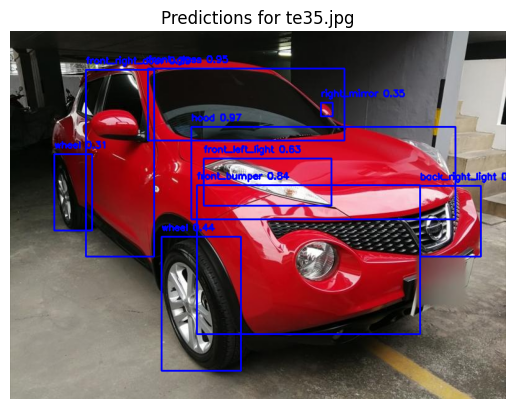


image 1/1 /content/car_parts_dataset/test/images/te25.jpg: 480x640 1 front_bumper, 1 front_glass, 1 front_left_light, 2 wheels, 14.9ms
Speed: 1.9ms preprocess, 14.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


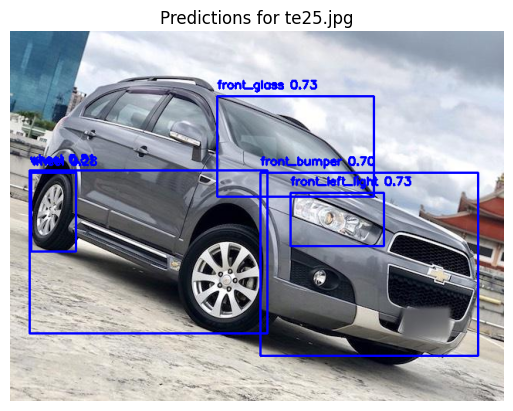

In [28]:
# Load the trained model
trained_model = YOLO("yolov8_car_parts_65.pt")

# Path to the test images
test_images_directory = "car_parts_dataset/test/images"

# Select two random test images
test_image_filenames = os.listdir(test_images_directory)
selected_image_filenames = random.sample(test_image_filenames, 2)

for image_filename in selected_image_filenames:
    image_filepath = os.path.join(test_images_directory, image_filename)

    try:
        detection_results = trained_model(image_filepath)
        image = cv2.imread(image_filepath)

        for detected_object in detection_results[0].boxes:
            x1, y1, x2, y2 = map(int, detected_object.xyxy[0])
            confidence_score = detected_object.conf[0]
            class_id = int(detected_object.cls[0])
            object_label = f"{trained_model.names[class_id]} {confidence_score:.2f}"
            cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
            cv2.putText(image, object_label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(f"Predictions for {image_filename}")
        plt.axis("off")
        plt.show()

    except Exception as e:
        print(f"Error processing image {image_filename}: {e}")

In [30]:
from collections import defaultdict

class_localization_difficulty = defaultdict(int)

for result in results:
    for detection_box in result.boxes:
        class_id = int(detection_box.cls[0])


        if detection_box.conf[0] < 0.5:
            class_localization_difficulty[class_id] += 1


class_localization_difficulty = dict(class_localization_difficulty)


print("Classes with high localization difficulty:")
for class_id, difficulty_score in class_localization_difficulty.items():
    class_name = model.names[class_id]
    print(f"  {class_name}: {difficulty_score}")

Classes with high localization difficulty:
  right_mirror: 1
